In [1]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# DATA PREPROCESSING

In [2]:
# Read the CSV file and create DataFrame
df1 = pd.read_csv('chatgpt_tweets.csv')

# Function to preprocess data
def preprocess_data(df):
    
    df = df.copy()
    
    # Delete unwanted columns
    del df['id']
    del df['username']
    del df['like_count']
    del df['retweet_count']
    
    # Drop rows with invalid date values
    df = df.dropna(subset=['date'])
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Coerce invalid dates to NaT

    # Drop rows with NaT (invalid dates)
    df = df.dropna(subset=['date'])
            
    # Delete the 'Unnamed: 6' column if it exists
    if 'Unnamed: 6' in df.columns:
        del df['Unnamed: 6']
    
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    
    # Remove numeric data from content column
    df['content'] = df['content'].str.replace('\d+', '', regex=True)
    
    # Remove URLs from content column
    df['content'] = df['content'].replace(to_replace=r'^https?:\/\/.*[\r\n]*', value='', regex=True)
    
    return df

# Preprocess the data
df1 = preprocess_data(df1)

df1.head()

,date,content
0,2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate..."
1,2023-03-29 22:58:18+00:00,@MecoleHardman Chat GPT says it’s . 😂
2,2023-03-29 22:57:53+00:00,Check out how this new AI quickly answers ques...
3,2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f..."
4,2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...


# SENTIMENTAL ANALYSIS USING VADER & TEXTBLOB

In [3]:

def perform_sentiment_analysis(df):
    # Create an instance of SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Add polarity score using TextBlob
    polarity_list_textblob = []
    for content in df['content']:
        blob = TextBlob(str(content))
        polarity_list_textblob.append(blob.sentiment.polarity)
    df['Polarity Score (TextBlob)'] = polarity_list_textblob
    
    # Add compound score using VADER
    compound_list_vader = []
    for content in df['content']:
        compound_score = analyzer.polarity_scores(str(content))['compound']
        compound_list_vader.append(compound_score)
    df['Compound Score (VADER)'] = compound_list_vader
    
    return df

# Perform sentiment analysis
df1 = perform_sentiment_analysis(df1)

df1.head()

,date,content,Polarity Score (TextBlob),Compound Score (VADER)
0,2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate...",0.268182,0.5106
1,2023-03-29 22:58:18+00:00,@MecoleHardman Chat GPT says it’s . 😂,0.000000,0.4404
2,2023-03-29 22:57:53+00:00,Check out how this new AI quickly answers ques...,0.248939,0.7184
3,2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f...",0.000000,0.0000
4,2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...,0.107143,0.0258


# COMPARISON OF BOTH METHODS

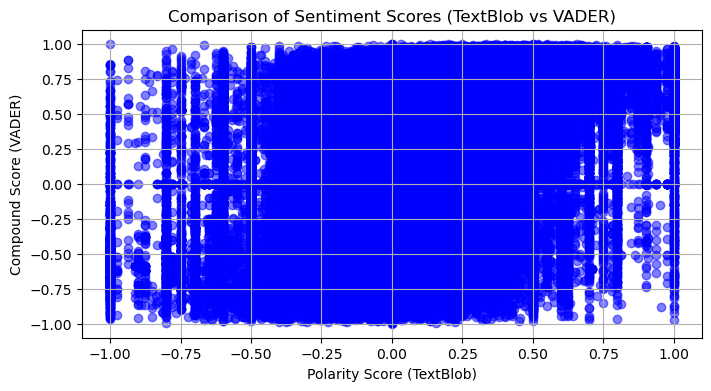

Correlation Coefficient: 0.43220360348082876


In [4]:

# Function to compare TextBlob and VADER sentiment scores
def compare_sentiment(df):
    plt.figure(figsize=(8, 4))
    plt.scatter(df['Polarity Score (TextBlob)'], df['Compound Score (VADER)'], color='blue', alpha=0.5)
    plt.title('Comparison of Sentiment Scores (TextBlob vs VADER)')
    plt.xlabel('Polarity Score (TextBlob)')
    plt.ylabel('Compound Score (VADER)')
    plt.grid(True)
    plt.show()

    # Calculate correlation coefficient
    correlation_coefficient = df['Polarity Score (TextBlob)'].corr(df['Compound Score (VADER)'])
    print("Correlation Coefficient:", correlation_coefficient)

# Compare sentiment scores and display summary
compare_sentiment(df1)

# VISUALIZING THE RESULT

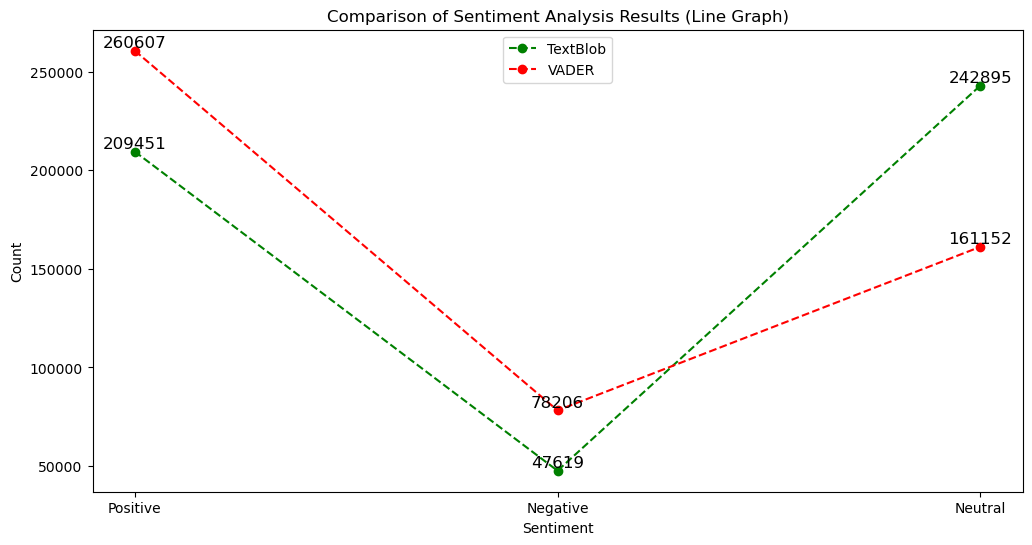

In [5]:
# Function to plot comparison of sentiment analysis results using line graph
def plot_line_comparison(df):
    # Count the number of tweets in each sentiment category for TextBlob
    textblob_positive = df[df['Polarity Score (TextBlob)'] > 0.1].shape[0]
    textblob_negative = df[df['Polarity Score (TextBlob)'] < -0.1].shape[0]
    textblob_neutral = df[(df['Polarity Score (TextBlob)'] >= -0.1) & (df['Polarity Score (TextBlob)'] <= 0.1)].shape[0]

    # Count the number of tweets in each sentiment category for VADER
    vader_positive = df[df['Compound Score (VADER)'] > 0.1].shape[0]
    vader_negative = df[df['Compound Score (VADER)'] < -0.1].shape[0]
    vader_neutral = df[(df['Compound Score (VADER)'] >= -0.1) & (df['Compound Score (VADER)'] <= 0.1)].shape[0]

    # Sentiment categories
    categories = ['Positive', 'Negative', 'Neutral']

    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Line plot for TextBlob
    plt.plot(categories, [textblob_positive, textblob_negative, textblob_neutral], color='green', linestyle='--', marker='o', label='TextBlob')
    
    # Line plot for VADER
    plt.plot(categories, [vader_positive, vader_negative, vader_neutral], color='red', linestyle='--', marker='o', label='VADER')

    # Add counts to the plot
    for i, count in enumerate([textblob_positive, textblob_negative, textblob_neutral]):
        plt.text(i, count + 5, f"{count}", ha='center', va='bottom', fontsize=12)
    
    for i, count in enumerate([vader_positive, vader_negative, vader_neutral]):
        plt.text(i, count + 5, f"{count}", ha='center', va='bottom', fontsize=12)

    # Axis labels and title
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Comparison of Sentiment Analysis Results (Line Graph)')
    
    # Legend
    plt.legend(loc='upper center')
    
    # Show plot
    plt.show()

# Call the function to plot the comparison
plot_line_comparison(df1)


# SENTIMENT TREND OVER TIME

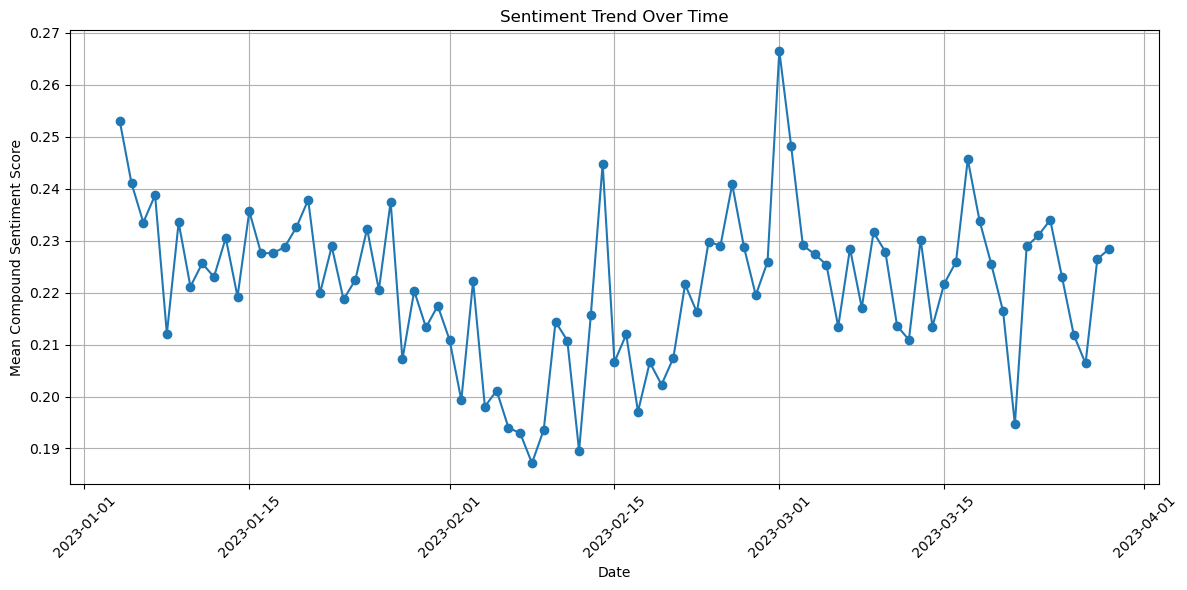

In [6]:
# Function to plot sentiment trend over time
def plot_sentiment_trend(df):
    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Group by date and calculate mean sentiment scores
    daily_sentiment = df.groupby(df['date'].dt.date)['Compound Score (VADER)'].mean()

    # Plot sentiment trend over time
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o', linestyle='-')
    plt.title('Sentiment Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Mean Compound Sentiment Score')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to plot sentiment trend
plot_sentiment_trend(df1)


# GENERATING WORDCLOUD

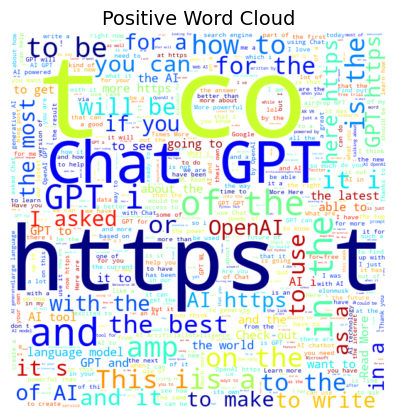

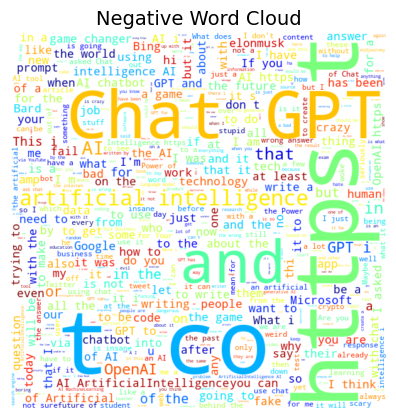

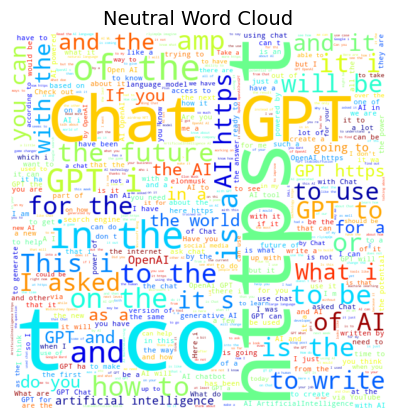

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define a function to generate word cloud
def generate_wordcloud(text, shape, title):
    stopword = set(['ChatGPT'])
    wordcloud = WordCloud(width=500, height=500, background_color='white', colormap='jet',
                          max_words=500, contour_width=3, contour_color='brown', 
                          mask=shape, stopwords=stopword).generate(text)
    plt.figure(figsize=(4, 4), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Extract text for positive, negative, and neutral tweets
positive_text = " ".join(df1[df1['Polarity Score (TextBlob)'] > 0.2]['content'])
negative_text = " ".join(df1[df1['Polarity Score (TextBlob)'] < -0.2]['content'])
neutral_text = " ".join(df1[(df1['Polarity Score (TextBlob)'] >= -0.2) & (df1['Polarity Score (TextBlob)'] <= 0.2)]['content'])

# Load shapes for the word clouds
positive_shape = np.array(Image.open("logo.png"))
negative_shape = np.array(Image.open("logo.png"))
neutral_shape = np.array(Image.open("logo.png"))

# Generate word clouds for positive, negative, and neutral tweets
generate_wordcloud(positive_text, positive_shape, "Positive Word Cloud")
generate_wordcloud(negative_text, negative_shape, "Negative Word Cloud")
generate_wordcloud(neutral_text, neutral_shape, "Neutral Word Cloud")



# OBSERVATIONS


**Total tweets Analyzed:** 544125

**Total Tweets after Data Cleaning:** 499785 

## Sentiment Distribution:

**VADER:**
* Positive Sentiment: 52.14%
* Negative Sentiment: 32.25%
* Neutal: 15.61%

**Textblob:**
* Positive Sentiment: 41.42%
* Negative Sentiment: 48.97%
* Neutal: 9.61%

**Corelation Coefficient:** 0.43

## Key Findings:

* **VADER** identified a significantly **higher proportion** of **positive sentiments** compared to TextBlob.
* **TextBlob** classified a significantly **higher proportion** of **negative sentiments** compared to VADER.
* Neutral sentiment was **lower for TextBlob** compared to VADER.
* A **correlation coefficient of 0.43** between TextBlob and VADER suggests a **moderately positive correlation** in their sentiment predictions. This means that, to some extent, the two tools tend to agree on the sentiment of the analyzed text. 
* However, it's important to note that a correlation of 0.43 is **not a perfect match.** 